## Deep Learning Fundamentals Assignment 2


Training a Classifier
=====================

We will be defining neural networks, computing loss and updating the weights of the network.

----------------
Specifically for vision, PyTorch includes a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

You can also implement your own dataloader based on ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

We will use the CINIC-10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CINIC-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CINIC-10.



### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

### Loading and Preparing Dataset

In [2]:
import torchvision
import torchvision.transforms as transforms

cinic_dir = 'D:/MDS/2023/4th Tri-3/DLF/Ass2/DS_10283_3192'
traindir = cinic_dir + '/train'
validatedir = cinic_dir + '/valid'
testdir = cinic_dir + '/test'

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
normalize = transforms.Normalize(mean=cinic_mean, std=cinic_std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

trainset = datasets.ImageFolder(root=traindir, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)

validateset = datasets.ImageFolder(root=validatedir, transform=transform)
validateloader = torch.utils.data.DataLoader(validateset,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=2)

testset = datasets.ImageFolder(root=testdir, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=True,
                                         num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Ensuring GPU is being used to train

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Printing some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


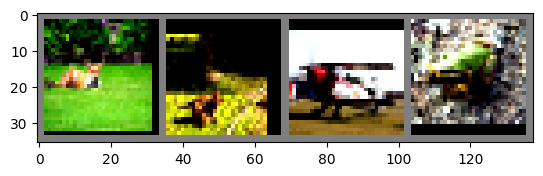

  dog   cat airplane  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# select the first 4 images
images = images[:4]
labels = labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Defining the Convolutional Neural Network

In [5]:

import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.to(self.conv1.weight.device)  # add this line
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        # print(x.shape)
        x = F.relu(self.conv5(x))
        # print(x.shape)
        x = self.pool3(x)
        x = self.dropout2(x)
        x = self.adaptive_pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=16, out_features=10, bias=

In [6]:

# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# print(net)


In [7]:
#TODO CHECK THE ERROR OM TORCHVIEW

### Visualizing the model

c:\PythonEnvironments\TorchEnv\lib\site-packages\torch\nn\functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "

(dot.exe:16256): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


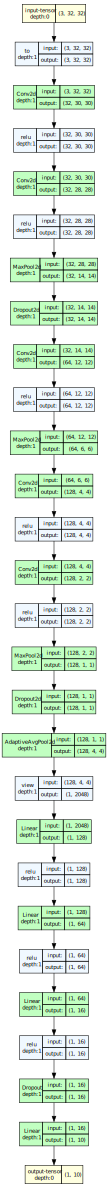

In [8]:
# #https://torchview.dev/
# #https://github.com/mert-kurttutan/torchview
from torchview import draw_graph
model_graph = draw_graph(net, input_size=(3,32,32), expand_nested=True)
model_graph.visual_graph

In [9]:
from torchsummary import summary

net = Net()
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
         Dropout2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
            Conv2d-8            [-1, 128, 2, 2]         147,584
         MaxPool2d-9            [-1, 128, 1, 1]               0
        Dropout2d-10            [-1, 128, 1, 1]               0
AdaptiveAvgPool2d-11            [-1, 128, 4, 4]               0
           Linear-12                  [-1, 128]         262,272
           Linear-13                   [-1, 64]           8,256
           Linear-14                   

In [10]:
#https://appsilon.com/visualize-pytorch-neural-networks/
#TODO Visulaize
# from torchviz import make_dot

# model = Net()
# y = model(X)

In [11]:
# from torchviz import make_dot
# #https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch

# #Backward pass apparently,
# # TODO check on this later
# batch = next(iter(dataloader_train))
# yhat = model(batch.text) # Give dummy batch to forward().

# make_dot(yhat, params=dict(list(model.named_parameters()))).render("cnn_torchviz", format="png")



In [12]:
# import hiddenlayer as hl
# #https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch

# #Forward pass apparently,
# # TODO check on this later
# transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

# graph = hl.build_graph(model, batch.text, transforms=transforms)
# graph.theme = hl.graph.THEMES['blue'].copy()
# graph.save('rnn_hiddenlayer', format='png')

### Defining a Loss function and optimizer

In [15]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
# torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
# inputs = inputs.to(device)
# outputs = net(inputs)
print(device)

cuda:0


### Training the model

In [16]:
epoch_num = 200

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total
             
def recall(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    true_positives = ((predicted == labels) & (labels == 1)).sum().item()
    false_negatives = ((predicted != labels) & (labels == 1)).sum().item()
    denominator = true_positives + false_negatives
    if denominator == 0:
        return 0
    else:
        return true_positives / denominator

def precision(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    true_positives = ((predicted == labels) & (labels == 1)).sum().item()
    false_positives = ((predicted != labels) & (labels == 0)).sum().item()
    denominator = true_positives + false_positives
    if denominator == 0:
        return 0
    else:
        return true_positives / denominator
        
def train_model_one_epoch(model, trainloader, optimizer, criterion, device):
    model.train()
    
    result = {'loss': 0,
             'accuracy': 0,
             'recall': 0,
             'precision': 0}
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        result['loss'] += loss.item()
        result['accuracy'] += accuracy(outputs, labels)
        result['recall'] += recall(outputs, labels)
        result['precision'] += precision(outputs, labels)

        loss.backward()
        optimizer.step()
        
    result = {k: v / len(trainloader) for k, v in result.items()}
    return result 

def valid_model(model, validloader, criterion, device):
    result = {'loss': 0,
             'accuracy': 0,
             'recall': 0,
             'precision': 0}
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            result['loss'] += loss.item()
            result['accuracy'] += accuracy(outputs, labels)
            result['recall'] += recall(outputs, labels)
            result['precision'] += precision(outputs, labels)

    result = {k: v / len(validloader) for k, v in result.items()}
    return result

def train_model(model, trainloader, validloader, optimizer, criterion, num_epochs, device):
    best_valid_perform = None
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_perform = train_model_one_epoch(model, trainloader, optimizer, criterion, device)
        valid_perform = valid_model(model, validloader, criterion, device)
        if best_valid_perform is None or valid_perform['accuracy'] > best_valid_perform['accuracy']:
            best_valid_perform = valid_perform
            torch.save(model.state_dict(), 'best_valid.pt')
        print(f'Epoch {epoch+1}: Train Loss={train_perform["loss"]:.4f}, Train Acc={train_perform["accuracy"]:.4f}, Valid Loss={valid_perform["loss"]:.4f}, Valid Acc={valid_perform["accuracy"]:.4f}')
        train_losses.append(train_perform['loss'])
        valid_losses.append(valid_perform['loss'])

    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_perform, valid_perform

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_perform, valid_perform = train_model(net, trainloader, validateloader, optimizer, criterion, epoch_num, device)

print('Finished Training')

Epoch 1: Train Loss=2.3061, Train Acc=0.0999, Valid Loss=2.3031, Valid Acc=0.1000
Epoch 2: Train Loss=2.3029, Train Acc=0.1000, Valid Loss=2.3025, Valid Acc=0.1000
Epoch 3: Train Loss=2.3026, Train Acc=0.1030, Valid Loss=2.3024, Valid Acc=0.1000
Epoch 4: Train Loss=2.3024, Train Acc=0.1041, Valid Loss=2.3021, Valid Acc=0.1099
Epoch 5: Train Loss=2.3021, Train Acc=0.1128, Valid Loss=2.3014, Valid Acc=0.1506
Epoch 6: Train Loss=2.2998, Train Acc=0.1329, Valid Loss=2.2954, Valid Acc=0.1456
Epoch 7: Train Loss=2.2620, Train Acc=0.1468, Valid Loss=2.1174, Valid Acc=0.1977
Epoch 8: Train Loss=2.0667, Train Acc=0.1898, Valid Loss=1.9453, Valid Acc=0.2185
Epoch 9: Train Loss=1.9674, Train Acc=0.2085, Valid Loss=1.9036, Valid Acc=0.2300
Epoch 10: Train Loss=1.9219, Train Acc=0.2331, Valid Loss=1.8573, Valid Acc=0.2513
Epoch 11: Train Loss=1.8875, Train Acc=0.2498, Valid Loss=1.8123, Valid Acc=0.2825
Epoch 12: Train Loss=1.8544, Train Acc=0.2702, Valid Loss=1.7809, Valid Acc=0.2952
Epoch 13: Tra

### Saving our model

In [17]:
PATH = './cinic_net.pth'
torch.save(net.state_dict(), PATH)

### Testing the model

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            if class_total[label] == 0:
                class_correct[label] = 0
            else:
                class_correct[label] += c[i].item()
            class_total[label] += 1
            correct += c[i].item()
            total += 1

for i in range(10):
    if class_total[i] == 0:
        print('Accuracy of %5s : N/A (no test images for this class)' % (classes[i]))
    else:
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

print('Overall accuracy of the network on the test images: %2d %%' % (100 * correct / total))

Accuracy of airplane : 78 %
Accuracy of automobile : 75 %
Accuracy of  bird : 71 %
Accuracy of   cat : 59 %
Accuracy of  deer : 68 %
Accuracy of   dog : 43 %
Accuracy of  frog : 83 %
Accuracy of horse : 77 %
Accuracy of  ship : 78 %
Accuracy of truck : 77 %
Overall accuracy of the network on the test images: 71 %
